In [1]:
import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import shelve as sl
import numpy.random as nprm
from matplotlib.lines import Line2D
import matplotlib

from gplotclass import plot_G
from Epifunc import plot_state_evolution, get_figgrid, TimeArrays

# to improve quality of the video
plt.rcParams['figure.dpi']  = 100
plt.rcParams['savefig.dpi'] = 100

### Reading the network

First, we read the network, aggregated in blocks of `dt=15` minutes for each day. This is equivalent to the DYN representation used in [1]

In [2]:
# initial time of the dataset
t0 = 28840
# days present in the dataset
days = list(range(0,5)) + list(range(7,12))
# hours of activity and time step (in seconds)
workinghours = 12*60*60
dt = 15*60
nblocks = int(24*60*60/dt)
nworkblocks = int(workinghours/dt)
blocks = range(0,nblocks)

file_meta = 'Data/metadata_InVS15.csv'
contact_meta = pd.read_csv(file_meta,names=['node name','class'],sep='\t').set_index('node name')

file = 'Data/tij_InVS15.csv'
daylynets = {}


for day in days:
    daylynets[day] = [ nx.Graph() for b in blocks ] 

f = open(file)

for line in f:
    (t,i,j) = line.split()
    ts = (int(t)-t0)//dt; i = int(i); j = int(j)
    day = ts//nblocks
    block = ts%nblocks
    if block < nworkblocks:
        if daylynets[day][block].has_edge(i,j):
            w = daylynets[day][block].get_edge_data(i,j)['weight']
        else:
            w = 0
        daylynets[day][block].add_edge(i,j,weight = w + 20)
f.close()
G15mins =  [ daylynets[day] for day in days ]

#### wrong index for G15mins!!! starts at 00h00

We can aggregate data even further into daily networks `G_dHET`, or an unique network for all the dataset `G_HET`

In [3]:
G_dHET = []

G0 =nx.Graph()
G0.add_nodes_from( contact_meta.index  )

G_HET = G0.copy()
for g_list in G15mins:
    gnew = G0.copy()
    for g in g_list:
        for u,v in g.edges:
            w = g[u][v]['weight']
            if gnew.has_edge(u,v):
                gnew[u][v]['weight'] =  gnew[u][v]['weight'] +  w
            else:
                gnew.add_edge(u, v, weight=w)
            if G_HET.has_edge(u,v):
                G_HET[u][v]['weight'] =  G_HET[u][v]['weight'] +  w   
            else:
                G_HET.add_edge(u, v, weight=w)
    G_dHET.append( gnew )


### Plotting a stating graph
First, we can use the library gplotclass to simply plot a network associated with a structured population.
We requiere a network in the format of a NetworkX graph $G_{uv}$, and a pandas dataframe indexed by the name of the nodes (which must coincide with the node names use in $G_{uv}$), and a column \verv+class+.

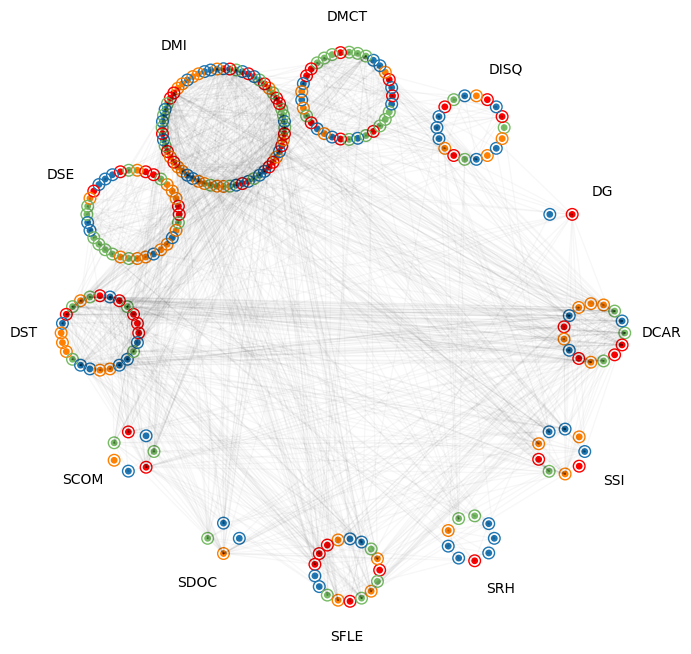

In [4]:
StateColors ={ 'S': '#77bc65',
               'E': '#ffbf00',
               'Ip': '#ff8000',
               'Ic': '#ff0000',
               'Isc': '#ff5429',
               'R': 'C0'}

G = G_dHET[0]

# create random states
nodes = [ nprm.choice(['S','Ic','Ip','R']) for i in contact_meta.index ]
# create a list with the colors associated to each state
nodes_color = [StateColors[s] for s in nodes]

fig, ax = plt.subplots(figsize=(8,8))
# create the class
Gplot = plot_G(contact_meta)
# plotting edges
Gplot.plotting_edges(G,alpha=0.03)
# plotting nodes
Gplot.plotting_nodes(G,s=15,c=nodes_color)
# plotting a bigger circle around 
Gplot.plotting_nodes(G,s=70,edgecolor=nodes_color,facecolors='none')
# add the label for each group
Gplot.plotting_group_label()
plt.axis('off')

plt.savefig('static.jpeg')


### Generating an animation
Now we can prepare an animation. We recover the history of states from a file which contains rows representing time, and columns with the state for each node. Then we associate each state to its respective color, creating a new array of colors in time.

We create a `time` array which contains the time (in days) for each timestep, and an instance of the `TimeOffice` class, which returns 

- `workingtime`: true when is an activity timestep.
- `data_day`: day associated with the timestep.
- `block_day`: index to recover the timestep within the day. 

Let's consider the timestep `nt = (14 + 5) * 24 * 4 + 36` `time[nt]= 5.375`, that correspond to a working hour `workingtime[nt]=True`, and to the day in the dataset `data_day[nt]=5` , and the  `block_day[nt]= 36` within the day. Put in another way, `nt = (14 + data_day) * nblocks + block_day`

In [5]:
Gplot = plot_G(contact_meta)
file_states = 'Data/state_OD_DYN_R=3.0_ST.csv'

state_history = np.array( pd.read_csv(file_states,names= contact_meta.index ) )
state_history_color = np.array([ [ StateColors[s] for s in S] for S in state_history])

tmax = 60
dt = 1/(24*4)
time = np.arange(0,tmax+dt,dt)
TO =  TimeArrays()
workingtime, block_day, data_day = TO.times(time)


To generate the video we define the function `update(num)` which updates the figure for each timestep `num`. Outside the function (and outside the axes `ax`, which is cleared for each frame) we can put other objects, such as the legend associated with the figure.

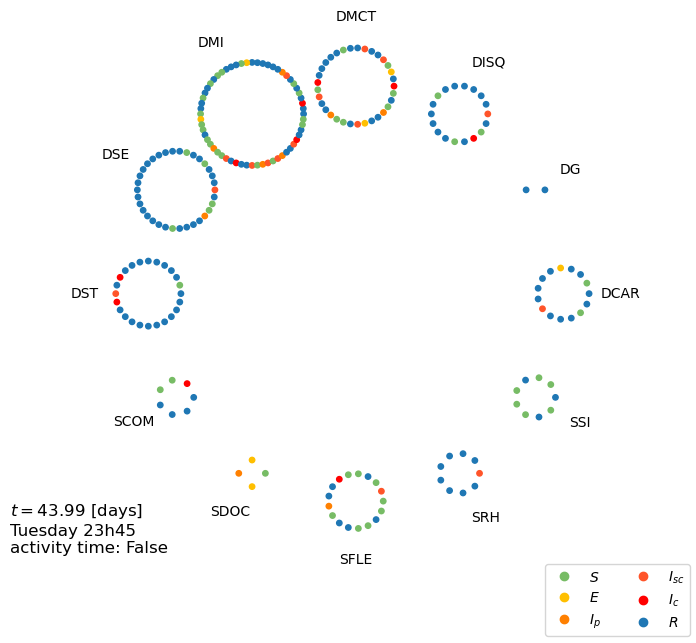

In [6]:
fig,ax = plt.subplots(1,1,figsize=(7,7))

# adding legend
StateLeg = {'$S$': StateColors['S'],'$E$': StateColors['E'],'$I_p$': StateColors['Ip'],
               '$I_{sc}$': StateColors['Isc'],'$I_c$': StateColors['Ic'],'$R$': StateColors['R'],}
legend_elements = [Line2D([0], [0], marker='o', color=color,lw=0,  label=S) for S,color in StateLeg.items()]
fig.legend(handles=legend_elements,ncol=2,
           loc=4 )

#graph without edges for times without activity
G0 =nx.Graph()
G0.add_nodes_from( np.arange( contact_meta.shape[0] )  )

def update(num):
    # num is the current time step
    ax.clear()
    nodes_color = state_history_color[num-1]
    TO.format_time(ax,time[num],workingtime[num],px=-8,py=-6)
    if workingtime[num]:
        ts =  block_day[num]
        day = data_day[num]
        G = G15mins[day][ts]
        weight = np.array( [ G[u][v]['weight'] for u,v in G.edges ] )
        # the number 1/600 was manually chosen to give an aestically coherent width to the edges
        # different networks would need a different number
        nweight = weight/600
        Gplot.plotting_edges(G,width=nweight)
    else:
        G = G0

    Gplot.plotting_nodes(G,s=15,c=nodes_color,facecolors='none')
    Gplot.plotting_group_label()
    ax.axis('off')
    ax.set_aspect('equal')


frames = range(43*24*4+30, 44*24*4)
ani = matplotlib.animation.FuncAnimation(fig, update,
                                         frames=frames, interval=1000)

writervideo = matplotlib.animation.FFMpegWriter(fps=6, bitrate=1024)
ani.save("video.mp4", writer=writervideo)

'h264'